# Key Drivers of Listing Prices and Price Prediction

In this notebook the AirBnB listings from Seattle from 2016 are used to find the features which influence the price of the listings most and build two models to predict the prices - linear regression and random forest regression. In accordance to the CRISP-DM process we first generate an understanding of the data, preprocess the data, build a model and evaluate it with supporting visualizations.

In [313]:
import datetime
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import robust_scale, scale
import seaborn as sns
%matplotlib inline

sns.set(style="ticks") # for improved visualizations of matplotlib graphs

# load the data from the listing
df_list = pd.read_csv("./listings.csv")
df_list.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


## Data Understanding and Preprocessing

In [314]:
# looking at the data types of the columns
df_list.dtypes

id                                    int64
listing_url                          object
scrape_id                             int64
last_scraped                         object
name                                 object
summary                              object
space                                object
description                          object
experiences_offered                  object
neighborhood_overview                object
notes                                object
transit                              object
thumbnail_url                        object
medium_url                           object
picture_url                          object
xl_picture_url                       object
host_id                               int64
host_url                             object
host_name                            object
host_since                           object
host_location                        object
host_about                           object
host_response_time              

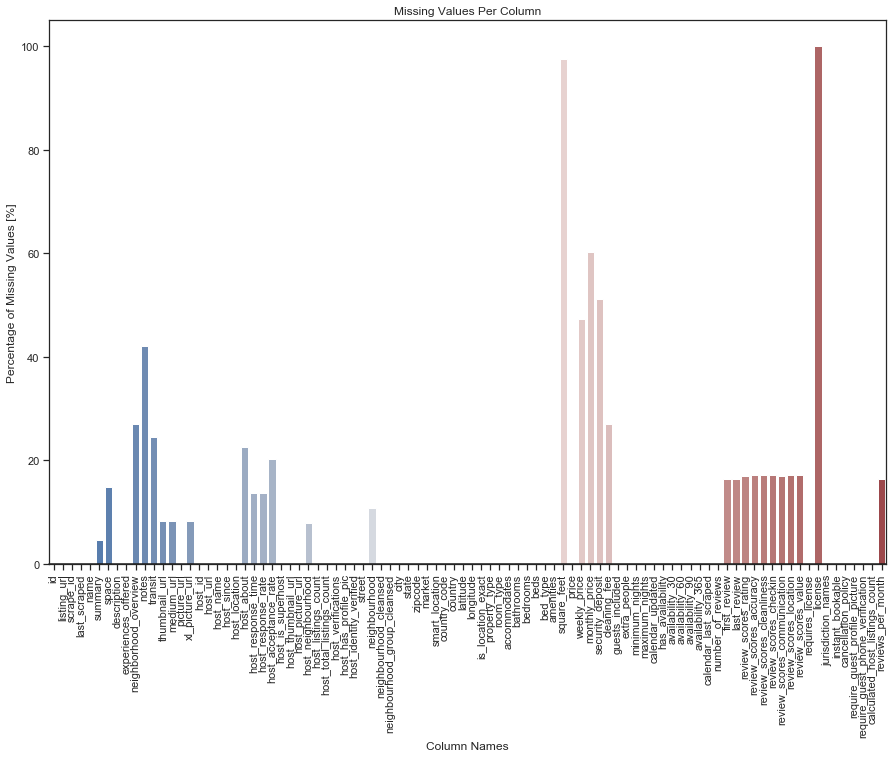

In [317]:
num_rows = df_list.shape[0] # number of listings
missing_values = [(df_list[col].isnull().sum() / num_rows) * 100 for col in df_list.columns] # percentage of values missing per column
headers = [col for col in df_list.columns]

# barplot illustrating the percentage of missing values per column
fig, ax = plt.subplots(figsize=(15,10))
plt.title("Missing Values Per Column")
plt.xlabel("Column Names")
plt.ylabel("Percentage of Missing Values [%]")
ax = sns.barplot(x=headers, y=missing_values, palette="vlag", ax=ax)
ax.axhline(0, color="k", clip_on=False)
plt.xticks(rotation=90);

In [318]:
# Remove columns with too many NaN values
def remove_columns(df, thresh):
    """
    Remove columns from the dataframe if fraction of NaN-values exceeds the given threshold.
    
    INPUT
    df - Pandas dataframe containing the data
    thresh - Proportion of NaN values allowed in a column, range [0-1]
    
    OUTPUT
    outlier_columns - List of column names with a proportion of NaN values higher than the threshold
    """
    outlier_columns = []
    num_rows = df.shape[0]
    for col in df.columns:
        if ((df[col].isnull().sum() / num_rows) > thresh):
            outlier_columns.append(col)
        
    return outlier_columns

# remove all columns with more than 30 % NaN values
outlier_col = remove_columns(df_list, 0.3)
df_list.drop(outlier_col, axis=1, inplace=True)

In [319]:
# all the quantitative variables in the dataframe
df_list.select_dtypes(include=["float64", "int64"]).columns

Index(['id', 'scrape_id', 'host_id', 'host_listings_count',
       'host_total_listings_count', 'latitude', 'longitude', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'guests_included', 'minimum_nights',
       'maximum_nights', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'calculated_host_listings_count',
       'reviews_per_month'],
      dtype='object')

In [320]:
id_columns = [col for col in df_list.columns if "id" in col] # columns which contain an id
# numerical columns to drop - all ids and additional columns with a non relevant impact on the price of a listing
# latitude and longitude are also just other values to represent the neighborhood which is considered in another variable
drop_num = id_columns + ["host_listings_count", "latitude", "longitude", "availability_30", "availability_60", "availability_90",
                        'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
                        'review_scores_communication', 'review_scores_location',
                        'review_scores_value', 'calculated_host_listings_count']
df_list.drop(drop_num, axis=1, inplace=True)

In [321]:
# obtain statistical values about all numerical values python can handle from the current dataframe
df_list.describe()

,host_total_listings_count,accommodates,bathrooms,bedrooms,beds,guests_included,minimum_nights,maximum_nights,availability_365,number_of_reviews,review_scores_rating,reviews_per_month
count,3816.000000,3818.000000,3802.000000,3812.000000,3817.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3171.000000,3191.000000
mean,7.157757,3.349398,1.259469,1.307712,1.735394,1.672603,2.369303,780.447617,244.772656,22.223415,94.539262,2.078919
std,28.628149,1.977599,0.590369,0.883395,1.139480,1.311040,16.305902,1683.589007,126.772526,37.730892,6.606083,1.822348
min,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,20.000000,0.020000
25%,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,60.000000,124.000000,2.000000,93.000000,0.695000
50%,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1125.000000,308.000000,9.000000,96.000000,1.540000
75%,3.000000,4.000000,1.000000,2.000000,2.000000,2.000000,2.000000,1125.000000,360.000000,26.000000,99.000000,3.000000
max,502.000000,16.000000,8.000000,7.000000,15.000000,15.000000,1000.000000,100000.000000,365.000000,474.000000,100.000000,12.150000


In [322]:
# all the non-quantitative variables in the dataframe
df_list.select_dtypes(include=["object"]).columns

Index(['listing_url', 'last_scraped', 'name', 'summary', 'space',
       'description', 'experiences_offered', 'neighborhood_overview',
       'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_verifications', 'host_has_profile_pic', 'street', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'city',
       'state', 'zipcode', 'market', 'smart_location', 'country_code',
       'country', 'is_location_exact', 'property_type', 'room_type',
       'bed_type', 'amenities', 'price', 'cleaning_fee', 'extra_people',
       'calendar_updated', 'has_availability', 'calendar_last_scraped',
       'first_review', 'last_review', 'requires_license', 'jurisdiction_names',
       'insta

In [323]:
url_columns = [col for col in df_list.columns if "url" in col] # all columns containing an url/link
name_columns = ["name", "host_name"] # columns containing a name
date_columns = ["last_scraped", "first_review", "last_review", "calendar_last_scraped", "host_since"] # columns containing a date
text_columns = ["summary", "space", "description", "neighborhood_overview", "transit", "host_about"] # columns with text field
# columns with duplicate information regarding the neighborhood
other_neighbor_columns = ["neighbourhood", "neighbourhood_cleansed", "zipcode", "street", "host_neighbourhood"]
# drop the columns
df_list.drop(url_columns+name_columns+date_columns+text_columns+other_neighbor_columns, axis=1, inplace=True)

In [324]:
df_list.select_dtypes(include=["object"]).columns # insepct remaining object columns

Index(['experiences_offered', 'host_location', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_verifications', 'host_has_profile_pic',
       'neighbourhood_group_cleansed', 'city', 'state', 'market',
       'smart_location', 'country_code', 'country', 'is_location_exact',
       'property_type', 'room_type', 'bed_type', 'amenities', 'price',
       'cleaning_fee', 'extra_people', 'calendar_updated', 'has_availability',
       'requires_license', 'jurisdiction_names', 'instant_bookable',
       'cancellation_policy', 'require_guest_profile_picture',
       'require_guest_phone_verification'],
      dtype='object')

In [325]:
df_list.select_dtypes(include=["object"]).head()

,experiences_offered,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_verifications,host_has_profile_pic,neighbourhood_group_cleansed,city,...,cleaning_fee,extra_people,calendar_updated,has_availability,requires_license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification
0,none,"Seattle, Washington, United States",within a few hours,96%,100%,f,"['email', 'phone', 'reviews', 'kba']",t,Queen Anne,Seattle,...,NaN,$5.00,4 weeks ago,t,f,WASHINGTON,f,moderate,f,f
1,none,"Seattle, Washington, United States",within an hour,98%,100%,t,"['email', 'phone', 'facebook', 'linkedin', 're...",t,Queen Anne,Seattle,...,$40.00,$0.00,today,t,f,WASHINGTON,f,strict,t,t
2,none,"Seattle, Washington, United States",within a few hours,67%,100%,f,"['email', 'phone', 'google', 'reviews', 'jumio']",t,Queen Anne,Seattle,...,$300.00,$25.00,5 weeks ago,t,f,WASHINGTON,f,strict,f,f
3,none,"Seattle, Washington, United States",NaN,NaN,NaN,f,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,Queen Anne,Seattle,...,NaN,$0.00,6 months ago,t,f,WASHINGTON,f,flexible,f,f
4,none,"Seattle, Washington, United States",within an hour,100%,NaN,f,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,Queen Anne,Seattle,...,$125.00,$15.00,7 weeks ago,t,f,WASHINGTON,f,strict,f,f


In [326]:
# further inspection (kaggle website is helpful here) of the data indicates that the values in the following columns are all the same and can hence be dropped
same_val_columns = ["jurisdiction_names", "host_location", "city", "state", "market", "country_code", "country", "smart_location"]
df_list.drop(same_val_columns, axis=1, inplace=True)

In [327]:
df_list.select_dtypes(include=["object"]).columns # inspect remaining object columns

Index(['experiences_offered', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_verifications',
       'host_has_profile_pic', 'neighbourhood_group_cleansed',
       'is_location_exact', 'property_type', 'room_type', 'bed_type',
       'amenities', 'price', 'cleaning_fee', 'extra_people',
       'calendar_updated', 'has_availability', 'requires_license',
       'instant_bookable', 'cancellation_policy',
       'require_guest_profile_picture', 'require_guest_phone_verification'],
      dtype='object')

In [328]:
# some of the columns are actually booleans but contain the values "t" or "f"
def get_bool(val):
    """
    Converts the value (t/f) into a boolean.
    
    INPUT
    val - Value to be converted into a boolean
    
    OUTPUT
    val - Original value converted to a boolean
    """
    if pd.isnull(val) is False:
        if val == "t":
            return True
        elif val == "f":
            return False
        # in case the column is already a boolean
        elif val == True or val == False:
            return val
        # in case the function receives an unexpected value
        else:
            raise ValueError("Function received unexpected value {}".format(val))
    else:
        return val
        
def df_columns_to_boolean(df, column_names):
    """
    Convert the values in certain columns to booleans.
    
    INPUT
    df - Pandas dataframe containing the columns to convert
    column_names - List of strings for the column names to convert
    
    OUTPUT
    df - Pandas dataframe with the columns converted to booleans
    """
    for col in column_names:
        df[col] = df[col].apply(lambda col: get_bool(col)).astype("bool")
    return df

# columns which will be converted to booleans
bool_columns = ["host_is_superhost", "host_has_profile_pic", "is_location_exact", "has_availability", "requires_license", "instant_bookable", "require_guest_profile_picture", "require_guest_phone_verification"]
# convert the columns
df_list = df_columns_to_boolean(df_list, bool_columns)
df_list[bool_columns].describe()

,host_is_superhost,host_has_profile_pic,is_location_exact,has_availability,requires_license,instant_bookable,require_guest_profile_picture,require_guest_phone_verification
count,3818,3818,3818,3818,3818,3818,3818,3818
unique,2,2,2,1,1,2,2,2
top,False,True,True,True,False,False,False,False
freq,3038,3811,3412,3818,3818,3227,3497,3443


In [329]:
# from the above statistics we can see that two columns just contain one unique value and do not contain helpful information
# drop these columns
df_list.drop(["has_availability", "requires_license"], axis=1, inplace=True)

In [330]:
df_list.select_dtypes(include=["object"]).columns # insepct remaining object columns

Index(['experiences_offered', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_verifications',
       'neighbourhood_group_cleansed', 'property_type', 'room_type',
       'bed_type', 'amenities', 'price', 'cleaning_fee', 'extra_people',
       'calendar_updated', 'cancellation_policy'],
      dtype='object')

In [331]:
# the field experiences_offered has actually all values none but because of the missing capital letter
# it is not detected as such here
print("The column experiences_offered has {} values different than none.".format(np.sum(df_list["experiences_offered"] != "none")))
# hence drop the column
df_list.drop(["experiences_offered"], axis=1, inplace=True)

The column experiences_offered has 0 values different than none.


In [332]:
# it is assumed that the different types how hosts are verified do not lead to different prices and also when the calendar was last updated
non_relevant_objects = ["host_verifications", "calendar_updated"]
df_list.drop(non_relevant_objects, axis=1, inplace=True)

In [333]:
# the dataframe contains some columns with % and need to be converted to numeric columns
# columns to convert to percentages
objects_to_perc = ["host_response_rate", "host_acceptance_rate"]

In [334]:
# convert the percentages into for python numerical values
def percentage_to_number(df, column_names):
    """
    Replaces the percentages in the columns with floats.
    
    INPUT
    df - Pandas dataframe containing the columns with percentage values
    column_names - List of column names which contain the percentage values
    
    OUTPUT
    df - Pandas dataframe with numbers instead of percentage values
    """
    for col in column_names:
        df[col] = df[col].apply(lambda col: float(str.replace(str(col), "%", "")))
    return df

df_list = percentage_to_number(df_list.copy(), objects_to_perc)

In [335]:
df_list.select_dtypes(include=["object"]).columns # insepct remaining object columns

Index(['host_response_time', 'neighbourhood_group_cleansed', 'property_type',
       'room_type', 'bed_type', 'amenities', 'price', 'cleaning_fee',
       'extra_people', 'cancellation_policy'],
      dtype='object')

In [336]:
# additionally, there are columns which are prices but expected to be numerical as well
def dollar_to_num(df, column_names):
    """
    Replaces the price values in the columns with floats.
    
    INPUT
    df - Pandas dataframe containing the columns with prices in $
    column_names - List of column names which contain the prices
    
    OUTPUT
    df - Pandas dataframe with numbers for the price instead of an object
    """
    for col in column_names:
        df[col] = df[col].apply(lambda col: float(str.replace(str(col), "$", "").replace(",", "")))
    return df


# columns to convert
objects_to_num = ["price", "cleaning_fee", "extra_people"]        
df_list = dollar_to_num(df_list.copy(), objects_to_num)

In [337]:
df_list.select_dtypes(include=["object"]).columns # insepct remaining object columns

Index(['host_response_time', 'neighbourhood_group_cleansed', 'property_type',
       'room_type', 'bed_type', 'amenities', 'cancellation_policy'],
      dtype='object')

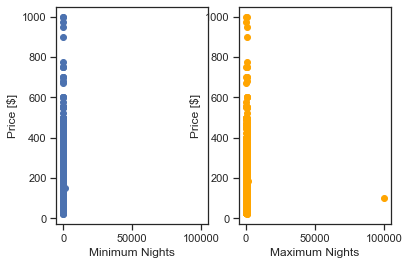

In [338]:
# analyze the impact of the minimum and maximum nights
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True)
axes[0].scatter(df_list["minimum_nights"], df_list["price"])
axes[0].set_xlabel("Minimum Nights")
axes[0].set_ylabel("Price [$]")
axes[1].scatter(df_list["maximum_nights"], df_list["price"], color="orange")
axes[1].set_xlabel("Maximum Nights")
axes[1].set_ylabel("Price [$]")
plt.show()

The minimum and maximum nights contain 1 outlier at around 1000. Moreover, there seems to be no correlation between the minimum or maximum nights and the price. Hence, drop them.

In [339]:
# drop minimum/maximum nights
df_list.drop(['minimum_nights', 'maximum_nights'], axis=1, inplace=True)

In [340]:
# inspect the column amenities
df_list["amenities"][:2]

0    {TV,"Cable TV",Internet,"Wireless Internet","A...
1    {TV,Internet,"Wireless Internet",Kitchen,"Free...
Name: amenities, dtype: object

In [341]:
# the amenities are listed in a kind of set but cannot be converted to dummy variables in this form
# find possible amenities first
def remove_chars_and_list(string, chars_to_remove=['"', "{", "}"], split_by=","):
    """
    Remove all chars in a string and split it into a list.
    
    INPUT
    string - The string to inspect and split
    chars_to_remove - A list of chars to be removed from the string
    split_by - Char by which the string should be splitted by
    
    OUTPUT
    string_splitted - A list of strings created from the original passed string
    """
    for char in chars_to_remove:
        string = string.replace(char, "")
    string_splitted = string.split(split_by)
    return string_splitted

# collect all possible options
amenities_options = []
for row in df_list["amenities"].values:
    amenities = remove_chars_and_list(row)
    for a in amenities:
        if a not in amenities_options and a != "":
            amenities_options.append(a)

In [342]:
print("There are {} possible amenities.".format(len(amenities_options)))

There are 41 possible amenities.


In [343]:
# now we neeed to create a column for each possible amenitie
def expand_amenities_to_cols(given_amenities, possible_amenities):
    """
    Create a new column for each amenities.
    
    INPUT
    given_amenities - List of amenities of the listing as strings
    possible_amenities - List of amenities possible as strings
    
    OUTPUT
    amenities_series - Pandas Series with booleans for each amenitie possible
    """
    given_amenities_listed = remove_chars_and_list(given_amenities)
    new_columns = defaultdict(bool)
    for amen in possible_amenities:
        if amen in given_amenities_listed:
            new_columns[amen] = True
        else:
            new_columns[amen] = False
    amenities_series = pd.Series(new_columns)
    return amenities_series

# append new columns with booleans for each amenitie and drop original column
df = df_list.merge(df_list["amenities"].apply(lambda col: expand_amenities_to_cols(col, amenities_options)),
                 left_index=True, right_index=True).drop("amenities", axis=1)
    


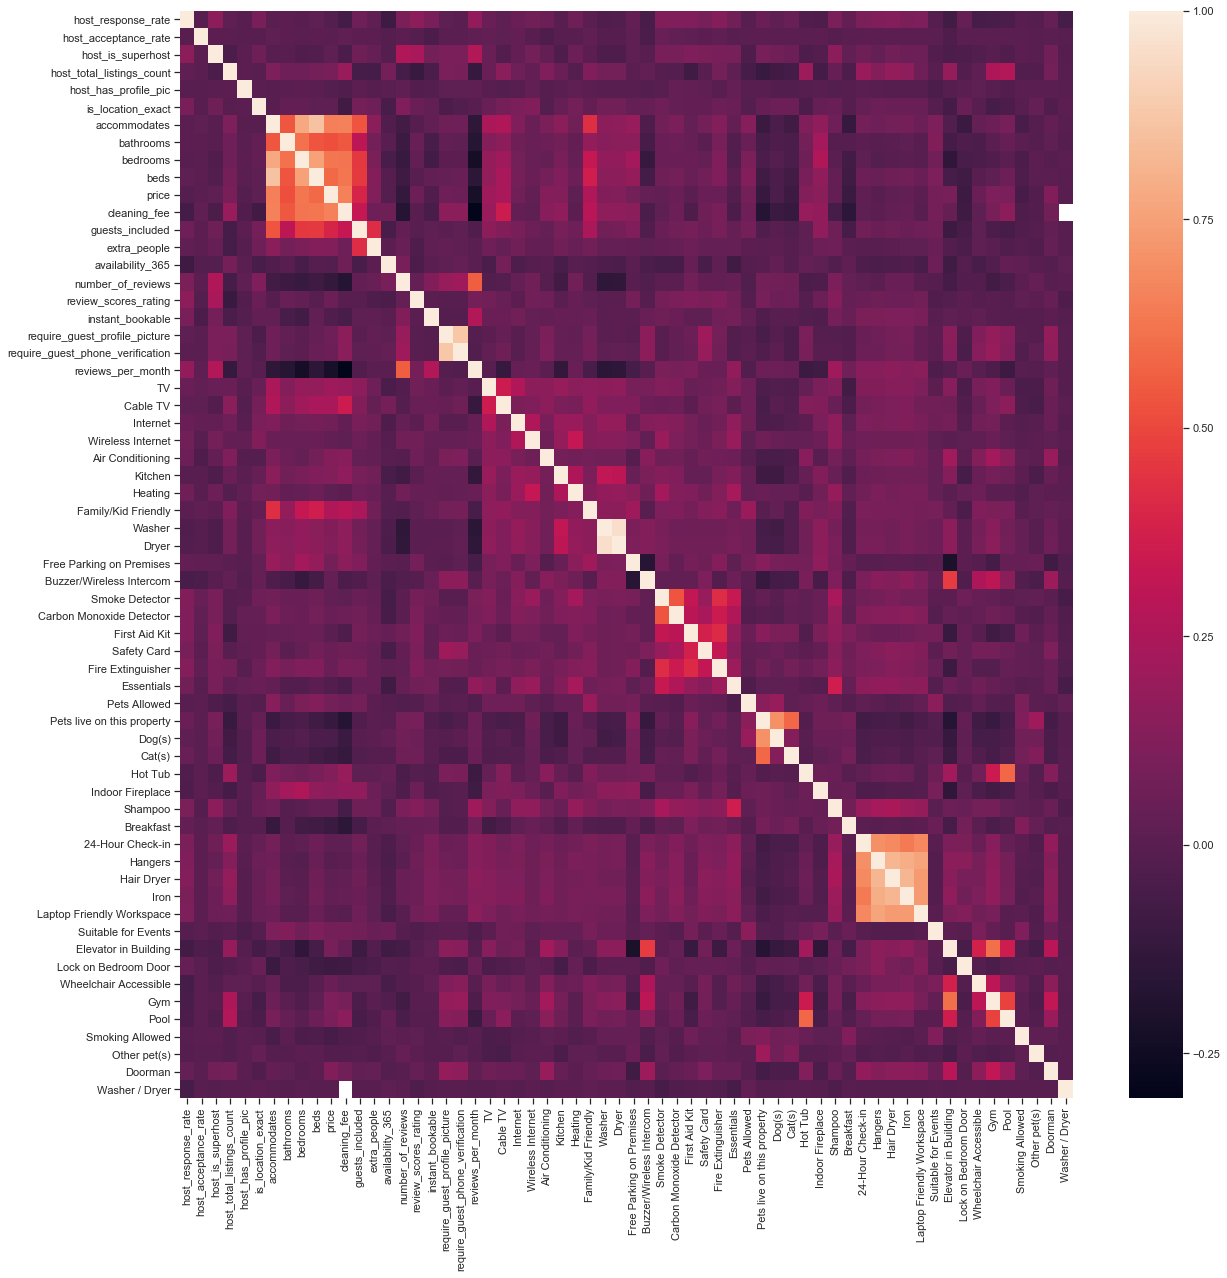

In [344]:
# create heatmap of correlation
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(df.corr(), annot=False, fmt='.2f', ax=ax)

In [345]:
# create correlation df for all amenities
corr_df = df.corr()[['TV', 'Cable TV', 'Internet', 'Wireless Internet',
       'Air Conditioning', 'Kitchen', 'Heating', 'Family/Kid Friendly',
       'Washer', 'Dryer', 'Free Parking on Premises',
       'Buzzer/Wireless Intercom', 'Smoke Detector',
       'Carbon Monoxide Detector', 'First Aid Kit', 'Safety Card',
       'Fire Extinguisher', 'Essentials', 'Pets Allowed',
       'Pets live on this property', 'Dog(s)', 'Cat(s)', 'Hot Tub',
       'Indoor Fireplace', 'Shampoo', 'Breakfast', '24-Hour Check-in',
       'Hangers', 'Hair Dryer', 'Iron', 'Laptop Friendly Workspace',
       'Suitable for Events', 'Elevator in Building', 'Lock on Bedroom Door',
       'Wheelchair Accessible', 'Gym', 'Pool', 'Smoking Allowed',
       'Other pet(s)', 'Doorman', 'Washer / Dryer']].reset_index()
# extract correlation to price
price_corr = corr_df[corr_df["index"] == "price"].drop("index", axis=1)
print(price_corr)
# mark only the amenities with a certain absolute correlation as relevant
relevant_amenities = []
for idx in np.where(price_corr.apply(lambda x: abs(x) > 0.1).sum(axis=0) > 0):
    relevant_amenities.append(price_corr.keys()[idx])
relevant_amenities

          TV  Cable TV  Internet  Wireless Internet  Air Conditioning  \
10  0.205824  0.237309   0.07628           0.027423          0.130271   

     Kitchen   Heating  Family/Kid Friendly    Washer     Dryer  ...  \
10  0.125024  0.017088             0.259901  0.120973  0.124589  ...   

    Suitable for Events  Elevator in Building  Lock on Bedroom Door  \
10             0.086932              0.093657             -0.097843   

    Wheelchair Accessible       Gym      Pool  Smoking Allowed  Other pet(s)  \
10               0.048867  0.113757  0.099141        -0.057203     -0.021662   

     Doorman  Washer / Dryer  
10  0.120872        -0.00659  

[1 rows x 41 columns]


[Index(['TV', 'Cable TV', 'Air Conditioning', 'Kitchen', 'Family/Kid Friendly',
        'Washer', 'Dryer', 'Pets live on this property', 'Hot Tub',
        'Indoor Fireplace', 'Breakfast', 'Gym', 'Doorman'],
       dtype='object')]

In [346]:
# drop the amenities which do not correlate much with the price
amenities_drop = [am for am in amenities_options if am not in relevant_amenities[0]]
df.drop(amenities_drop, axis=1, inplace=True)

## Modeling and Evaluation

In this part of the notebook the missing values are replaced, the data is splitted into train and test data and both a model for linear regression and random forest regression is created considering different cutoff values.

In [347]:
# check booleans
print("The boolean columns contain {} columns with NaN values.".format(np.sum(df.select_dtypes(["bool"]).isna().any())))

The boolean columns contain 0 columns with NaN values.


In [348]:
# check response variable
print("The response variable contains {} NaN values.".format(int(df["price"].isna().any())))
print("No need to drop any rows in the response variable.")

The response variable contains 0 NaN values.
No need to drop any rows in the response variable.


In [349]:
# check the numeric values - the NaN values should be replaced later
print("The numeric columns contain {} columns with NaN values.".format(np.sum(df.select_dtypes(["int64", "float64"]).isna().any())))

The numeric columns contain 9 columns with NaN values.


In [350]:
# check categorical variables
print("The object columns contain {} columns with NaN values.".format(np.sum(df.select_dtypes(["object"]).isna().any())))

The object columns contain 2 columns with NaN values.


In [351]:
# which object variables contain NaN values
df.select_dtypes(["object"]).isna().any()

host_response_time               True
neighbourhood_group_cleansed    False
property_type                    True
room_type                       False
bed_type                        False
cancellation_policy             False
dtype: bool

In [352]:
def impute_and_dummy(df):
    """
    Impute values and create dummy variables.
    
    INPUT
    df - Pandas dataframe with the feature and response variables
    
    OUTPUT
    X - Dataframe with the feature variables
    y - Series with the response variable
    """
    y = df["price"]
    df = df.drop(["price"], axis=1)
    # Fill numeric columns with the mean
    num_vars = df.select_dtypes(include=['float64', 'int64']).columns
    for col in num_vars:
        df[col].fillna((df[col].mean()), inplace=True)
        
    # Dummy the categorical variables
    cat_vars = df.select_dtypes(include=['object']).copy().columns
    for var in  cat_vars:
        # for each cat add dummy var, drop original column
        df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)
    
    X = df
    return X, y

In [353]:
# create X and y by imputing values and generating dummy variables
X, y = impute_and_dummy(df)

In [354]:
print("The X-matrix has {} rows and {} variables.".format(X.shape[0], X.shape[1]))

The X-matrix has 3818 rows and 75 variables.


Number of variables is still smaller than the number of rows.

In [355]:
def split_and_fit(X, y, cutoffs, test_size=.30, random_state=15, plot=True):
    r2_scores_test, r2_scores_train, num_feats, results = [], [], [], dict()
    for cutoff in cutoffs:
        
        #reduce X matrix
        reduce_X = X.iloc[:, np.where((X.sum() > cutoff) == True)[0]]
        num_feats.append(reduce_X.shape[1])

        #split the data into train and test
        X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

        #fit the model and obtain pred response
        lm_model = LinearRegression(normalize=True) 
        lm_model.fit(X_train, y_train)
        y_test_preds = lm_model.predict(X_test)
        y_train_preds = lm_model.predict(X_train)
        
        #append the r2 value from the test set
        r2_scores_test.append(r2_score(y_test, y_test_preds))
        r2_scores_train.append(r2_score(y_train, y_train_preds))
        results[str(cutoff)] = r2_score(y_test, y_test_preds)
    
    if plot:
        plt.plot(num_feats, r2_scores_test, label="Test", alpha=.5)
        plt.plot(num_feats, r2_scores_train, label="Train", alpha=.5)
        plt.xlabel('Number of Features')
        plt.ylabel('Rsquared')
        plt.title('Rsquared by Number of Features')
        plt.legend(loc=0)
        plt.show()
        
    best_cutoff = max(results, key=results.get)
    
    #reduce X matrix
    reduce_X = X.iloc[:, np.where((X.sum() > int(best_cutoff)) == True)[0]]
    num_feats.append(reduce_X.shape[1])

    #split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

    #fit the model
    lm_model = LinearRegression(normalize=True) 
    lm_model.fit(X_train, y_train)
        
    return r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test 

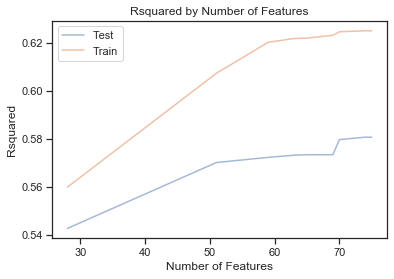

In [356]:
cutoffs = [1000, 100, 50, 30, 20, 10, 5, 1, 0]
r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test = split_and_fit(X, y, cutoffs)

In [357]:
print("The maximal r2-score for LinearRegression on the test data is {}".format(np.max(r2_test)))

The maximal r2-score for LinearRegression on the test data is 0.6117974799572896


In [358]:
print("The mean squared error for LinearRegression on the test data is {}".format(mean_squared_error(y_test, y_test_preds)))


The mean squared error for LinearRegression on the test data is 3806.1008628631453


In [359]:
print("The mean absolute error for LinearRegression on the test data is {}".format(mean_absolute_error(y_test, y_test_preds)))


The mean absolute error for LinearRegression on the test data is 35.947396815681465


In [360]:
# inspect which coefficients have the highest influence on the price
coefs_df = pd.DataFrame() # new dataframe

coefs_df['feature'] = X_train.columns
coefs_df['coefs'] = lm_model.coef_
coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
coefs_df.sort_values('abs_coefs', ascending=False).head(20) # sort the values and show the first 20

,feature,coefs,abs_coefs
53,property_type_Boat,73.748295,73.748295
67,room_type_Shared room,-68.227668,68.227668
32,Doorman,43.433961,43.433961
56,property_type_Camper/RV,42.876468,42.876468
38,neighbourhood_group_cleansed_Cascade,42.189094,42.189094
41,neighbourhood_group_cleansed_Downtown,41.839916,41.839916
59,property_type_Dorm,-41.650508,41.650508
63,property_type_Tent,-40.316299,40.316299
66,room_type_Private room,-36.644718,36.644718
65,property_type_Treehouse,-33.097100,33.097100


In [361]:
# clean the neighbourhood-feature by removing the part in front of its name
str_to_remove = "neighbourhood_group_cleansed_"
remove_neighbourhood = lambda col: str.replace(col, str_to_remove, "") if str_to_remove in col else col
coefs_df["feature_cleaned"] = coefs_df["feature"].apply(remove_neighbourhood)


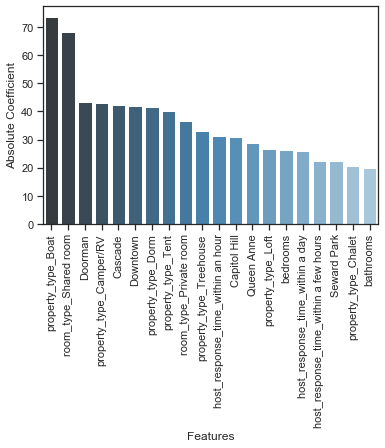

In [362]:
# bar plot to visualize the most important features
fig, ax1 = plt.subplots()
sns.barplot(x="feature_cleaned", y="abs_coefs", data=coefs_df.sort_values('abs_coefs', ascending=False)[:20],
                 palette="Blues_d", ax=ax1)
ax1.set_xlabel("Features")
ax1.set_ylabel("Absolute Coefficient")
plt.xticks(rotation=90); # rotate ticks for readability

In [363]:
# one of the best out of the box methods for supervised machine learning
# is known as the RandomForest - use this approach in addition to the previous linear model
def find_optimal_rf_mod(X, y, cutoffs, test_size = .30, random_state=42, plot=True, param_grid=None):
    """
    Find optimal random forest regression.
    
    INPUT
    X - pandas dataframe, X matrix
    y - pandas dataframe, response variable
    cutoffs - list of ints, cutoff for number of non-zero values in dummy categorical vars
    test_size - float between 0 and 1, default 0.3, determines the proportion of data as test data
    random_state - int, default 42, controls random state for train_test_split
    plot - boolean, default True, True to plot result
    param_grid - include the arguments you want to pass to the rf model
    
    OUTPUT
    r2_scores_test - list of floats of r2 scores on the test data
    r2_scores_train - list of floats of r2 scores on the train data
    rf_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    """

    r2_scores_test, r2_scores_train, num_feats, results = [], [], [], dict()
    for cutoff in cutoffs:

        #reduce X matrix
        reduce_X = X.iloc[:, np.where((X.sum() > cutoff) == True)[0]]
        num_feats.append(reduce_X.shape[1])

        #split the data into train and test
        X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

        #fit the model and obtain pred response
        if param_grid==None:
            rf_model = RandomForestRegressor()  #no normalizing here, but could tune other hyperparameters

        else:
            rf_inst = RandomForestRegressor(n_jobs=-1, verbose=1)
            rf_model = GridSearchCV(rf_inst, param_grid, n_jobs=-1) 
            
        rf_model.fit(X_train, y_train)
        y_test_preds = rf_model.predict(X_test)
        y_train_preds = rf_model.predict(X_train)

        #append the r2 value from the test set
        r2_scores_test.append(r2_score(y_test, y_test_preds))
        r2_scores_train.append(r2_score(y_train, y_train_preds))
        results[str(cutoff)] = r2_score(y_test, y_test_preds)

    if plot:
        plt.plot(num_feats, r2_scores_test, label="Test", alpha=.5)
        plt.plot(num_feats, r2_scores_train, label="Train", alpha=.5)
        plt.xlabel('Number of Features')
        plt.ylabel('Rsquared')
        plt.title('Rsquared by Number of Features')
        plt.legend(loc=1)
        plt.show()
        
    best_cutoff = max(results, key=results.get)

    #reduce X matrix
    reduce_X = X.iloc[:, np.where((X.sum() > int(best_cutoff)) == True)[0]]
    num_feats.append(reduce_X.shape[1])

    #split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

    #fit the model
    if param_grid==None:
        rf_model = RandomForestRegressor()  #no normalizing here, but could tune other hyperparameters

    else:
        rf_inst = RandomForestRegressor(n_jobs=-1, verbose=1)
        rf_model = GridSearchCV(rf_inst, param_grid, n_jobs=-1) 
    rf_model.fit(X_train, y_train)
     
    return r2_scores_test, r2_scores_train, rf_model, X_train, X_test, y_train, y_test

C:\Users\FRANZK1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    9.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   10.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s


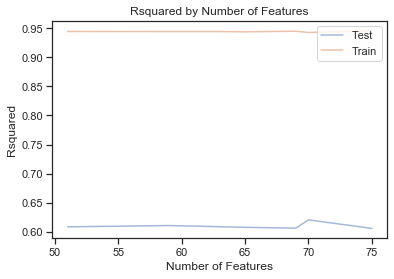

C:\Users\FRANZK1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   11.1s finished


In [206]:
cutoffs = [100, 50, 30, 20, 10, 5, 0]
params = {'n_estimators': [5, 10, 100, 1000], 'max_depth': [1, 5, 10, 100, 200]}
r2_test_rf, r2_train_rf, rf_model, X_train_rf, X_test_rf, y_train_rf, y_test_rf = find_optimal_rf_mod(X, y, cutoffs, param_grid=params)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.5s finished


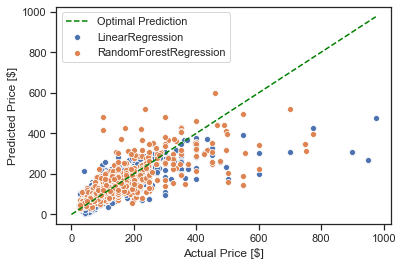

In [364]:
# predicted prices for the test data
y_test_preds = lm_model.predict(X_test)
y_test_preds_rf = rf_model.predict(X_test_rf)

# plot the deviations between predictions and actual prices for both approaches
fig, ax = plt.subplots()
sns.scatterplot(x=y_test, y=y_test_preds, palette="muted", ax=ax, label="LinearRegression")
sns.scatterplot(x=y_test_rf, y=y_test_preds_rf, palette="muted", ax=ax, label="RandomForestRegression")

plt.plot([0, max(y_test)], [0, max(y_test)], color="green", linestyle="--", label="Optimal Prediction")
ax.set_xlabel("Actual Price [$]")
ax.set_ylabel("Predicted Price [$]")
ax.legend() # activate legend

In [365]:
print("The maximal r2-score for RandomForestRegression on the test data is {}".format(np.max(r2_test_rf)))

The maximal r2-score for RandomForestRegression on the test data is 0.6206603144040338


In [366]:
print("The mean squared error for RandomForestRegression on the test data is {}".format(mean_squared_error(y_test_rf, y_test_preds_rf)))


The mean squared error for RandomForestRegression on the test data is 3375.227162387179


In [367]:
print("The mean absolute error for LinearRegression on the test data is {}".format(mean_absolute_error(y_test_rf, y_test_preds_rf)))


The mean absolute error for LinearRegression on the test data is 33.69401705310396
